# Stock Price Prediction using Machine Learning (ML)

We will use Scikit-Learn library for ML

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Any
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Get Historical Data
def get_stock_data(ticker: str, start_date: str, end_date: str) -> Any:
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [3]:
# Feature Engineering

def engineer_features(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()

    # Calculate daily Return
    df["Return"] = df["Close"].pct_change()

    # Calculate Moving Averages
    df["SMA_5"] = df["Close"].rolling(window=5).mean()
    df["SMA_10"] = df["Close"].rolling(window=10).mean()

    # Calculate volatility: 5-day Standard deviation from the closing prices
    df["Volatility_5"] = df["Close"].rolling(window=5).std()

    # Create lag features: Closing price from 1, 2, 3 days ago
    for i in range(1, 6): # If you increase the lag features here, also update prepare_data(), predict_next_day()
        df[f"Close_lag{i}"] = df["Close"].shift(i)

    # Target: This is what we want to predict: Tomorrow's Closing Price
    df["Target"] = df["Close"].shift(-1)

    print("\nProcessed Data:\n")
    print(df.head(15))

    # Remove rows with missing values
    df.dropna(inplace=True)

    return df    

In [4]:
# Prepare Data for Modeling

def prepare_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    features = [
        "Close_lag1",
        "Close_lag2",
        "Close_lag3",
        "Close_lag4",
        "Close_lag5",
        "SMA_5",
        "SMA_10",
        "Volatility_5",
        "Return"
    ]
    X = df[features]
    y = df["Target"]
    return X, y

In [5]:
# Train-Test Split of Time Series Data

def train_test_split_ts(X: pd.DataFrame, y: pd.Series, split: float = 0.8) -> Tuple:
    split_idx = int(len(X) * split)
    return(
        X.iloc[:split_idx],
        X.iloc[split_idx:],
        y.iloc[:split_idx],
        y.iloc[split_idx:]
    )

In [6]:
# Model Training

def train_model(X_train: pd.DataFrame, y_train: pd.Series, model_type: str = "lr") -> Any:
    if model_type == "lr":
        model = LinearRegression()
    else:
        print("Model Type Not Available")
    model.fit(X_train, y_train)
    return model

In [7]:
# Model Evaluation

def evaluate_model(model: Any, X_test: pd.DataFrame, y_test: pd.Series) -> Dict[str, float]:
    y_pred = model.predict(X_test)
    return {
        "mse": mean_squared_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
        "predictions": y_pred,
    }

In [8]:
# Plot Predictions

def plot_predictions(y_test: pd.Series, y_pred: np.ndarray, ticker: str, model_type: str):
    plt.figure(figsize=(12,6))
    plt.plot(y_test.index, y_test, label="Actual Price", color="blue")
    plt.plot(y_test.index, y_pred, label="Predicted Price", color="orange")
    plt.title(f"{ticker} Actual vs Predicted Prices ({model_type})")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()
    

In [9]:
# Predict next day price

def predict_next_day(model: Any, latest_data: pd.Series) -> float:
    features = [
        "Close_lag1",
        "Close_lag2",
        "Close_lag3",
        "Close_lag4",
        "Close_lag5",
        "SMA_5",
        "SMA_10",
        "Volatility_5",
        "Return"
    ]
    prediction_features = np.array([latest_data[f] for f in features]).reshape(1, -1)
    return model.predict(prediction_features)[0]

In [10]:
# Main Function

def main():
    start_date = "2018-02-07"
    end_date = "2025-02-07"
    stocks = ["TSLA", "META", "MA", "V", "NFLX", "AMZN", "GOOGL", "JPM", "MSFT"]
    prediction_date = "2025-02-10"

    results = {}

    for ticker in stocks:
        print(f"\nProcessing {ticker}...")

        # 1. Get the stock data
        data = get_stock_data(ticker, start_date, end_date)

        # 2. Create features from the data
        processed_data = engineer_features(data)

        # 3. Prepare the data for our model
        X, y = prepare_data(processed_data)

        # 4. Split the data into training and testing. Note: We are not shuffling data because order matters!
        X_train, X_test, y_train, y_test = train_test_split_ts(X, y)

        # 5. Train models
        models = {
            "Linear Regression": train_model(X_train, y_train, model_type="lr")
        }

        results[ticker] = {}
        for model_name, model in models.items():
            # 6. Evaluate model on test data
            eval_results = evaluate_model(model, X_test, y_test)
            # 7. Plot the "Predictions vs Actual Prices"
            plot_predictions(y_test, eval_results["predictions"], ticker, model_name)
            # 8. Predict Next Day Price
            next_day_price = predict_next_day(model, processed_data.iloc[-1])
            results[ticker][model_name] = {
                "metrics": eval_results,
                "prediction": next_day_price
            }
        print("\nPrediction Summary for", prediction_date)
        print("-" * 50)
        for ticker, models in results.items():
            print(f"\n{ticker}:")
            for model_name, result in models.items():
                print(f"  {model_name}:")
                print(f"    MSE: {result['metrics']['mse']:.2f}")
                print(f"    R2: {result['metrics']['r2']:.2f}")
                print(f"    Predicted Price: ${result['prediction']:.2f}")


Processing TSLA...


[*********************100%***********************]  1 of 1 completed


Processed Data:

Price           Close       High        Low       Open     Volume    Return  \
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA             
Date                                                                          
2018-02-07  23.000000  23.066668  22.377333  22.599333  104538000       NaN   
2018-02-08  21.015333  23.241333  20.973333  22.887333  154719000 -0.086290   
2018-02-09  20.694668  21.398666  19.650667  21.328667  194005500 -0.015259   
2018-02-12  21.048668  21.205334  20.416668  21.075333   93417000  0.017106   
2018-02-13  21.577333  21.612667  20.834000  21.001333   68403000  0.025116   
2018-02-14  21.487333  21.744667  21.234667  21.389334   59260500 -0.004171   
2018-02-15  22.271334  22.274668  21.493334  21.633333   88693500  0.036487   
2018-02-16  22.365999  22.874666  22.109333  22.166668   84639000  0.004251   
2018-02-20  22.318001  22.722668  22.100000  22.298000   60141000 -0.002146   
2018-02-21  22.219999  22.646000  

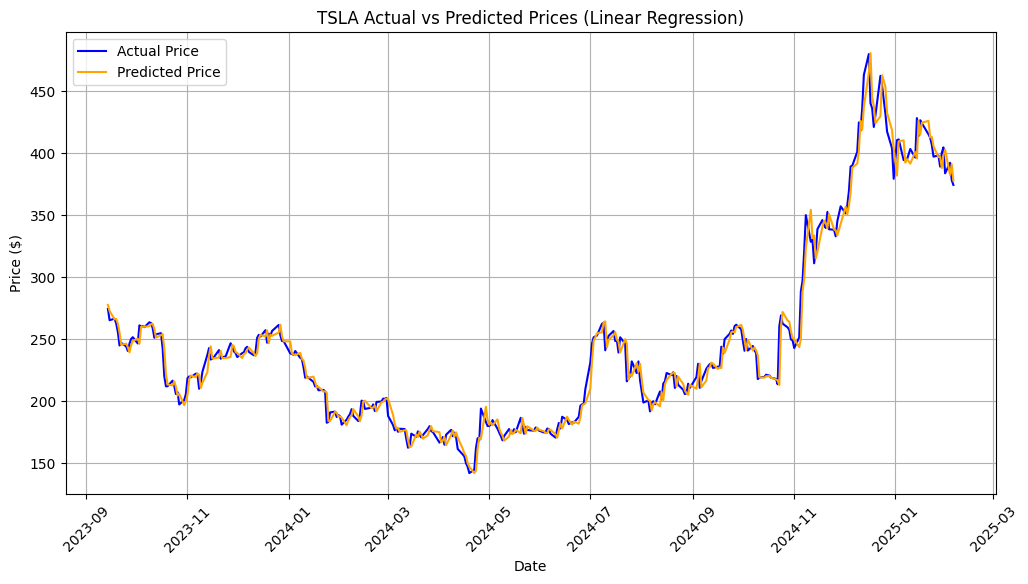


Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

Processing META...


[*********************100%***********************]  1 of 1 completed


Processed Data:

Price            Close        High         Low        Open    Volume  \
Ticker            META        META        META        META      META   
Date                                                                   
2018-02-07  179.494339  184.375702  179.265218  183.449233  27601900   
2018-02-08  170.927063  181.148014  170.827437  180.321170  38478300   
2018-02-09  175.439835  176.226822  166.543809  174.094966  39887600   
2018-02-12  175.738693  176.874354  171.186077  176.386214  32092100   
2018-02-13  172.491089  175.300365  172.441291  174.951691  21809400   
2018-02-14  178.836853  179.125743  172.550868  172.789945  28929700   
2018-02-15  179.275208  179.813146  176.167070  179.813146  20922100   
2018-02-16  176.685074  179.195488  175.629110  178.308876  20645300   
2018-02-20  175.340210  177.272830  174.443641  175.101133  21204900   
2018-02-21  177.233002  180.580216  175.728738  176.037571  23200800   
2018-02-22  178.308884  179.524242  176.734894

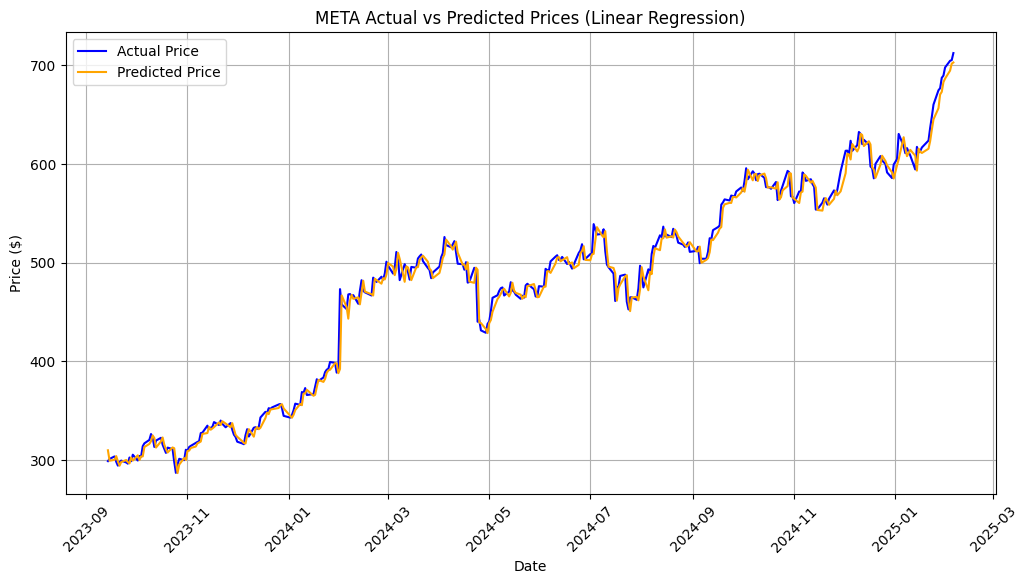


Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

META:
  Linear Regression:
    MSE: 104.93
    R2: 0.99
    Predicted Price: $702.48

Processing MA...


[*********************100%***********************]  1 of 1 completed


Processed Data:

Price            Close        High         Low        Open   Volume    Return  \
Ticker              MA          MA          MA          MA       MA             
Date                                                                            
2018-02-07  162.304916  166.037174  161.073659  162.564639  4364800       NaN   
2018-02-08  154.503708  162.795475  154.349812  162.343371  6557700 -0.048065   
2018-02-09  158.909317  160.150203  152.531792  155.513738  6303000  0.028515   
2018-02-12  161.785431  162.391446  159.274818  160.448362  5227400  0.018099   
2018-02-13  163.642044  164.267302  160.650468  160.958290  3471000  0.011476   
2018-02-14  165.950531  166.085199  162.564567  162.910859  4203700  0.014107   
2018-02-15  168.037949  168.047563  164.834751  167.326122  3915000  0.012579   
2018-02-16  168.961411  169.942574  167.508915  167.710925  4213100  0.005496   
2018-02-20  168.672791  169.711652  167.412662  168.220687  3750100 -0.001708   
2018-02-21

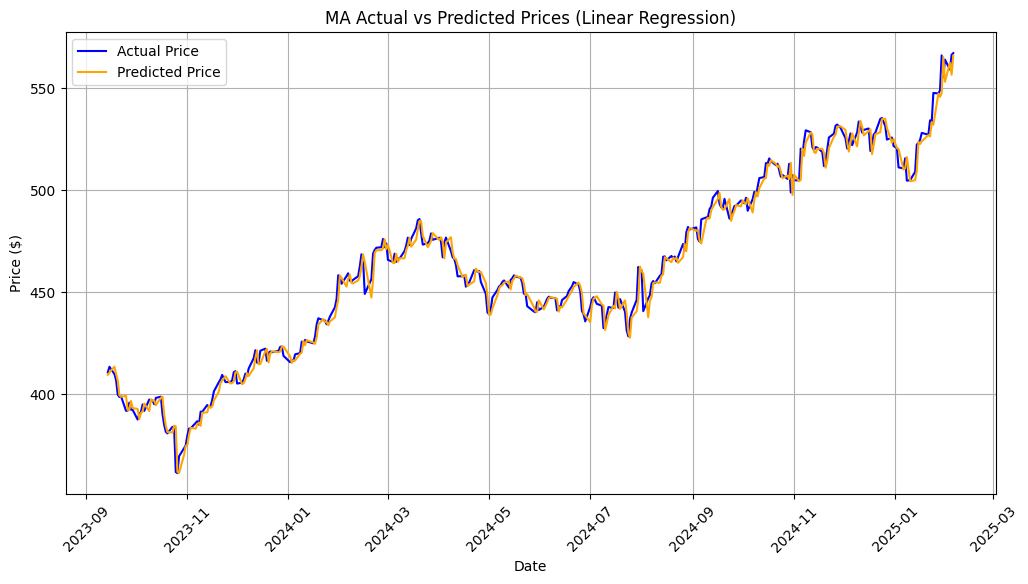


Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

META:
  Linear Regression:
    MSE: 104.93
    R2: 0.99
    Predicted Price: $702.48

MA:
  Linear Regression:
    MSE: 24.27
    R2: 0.99
    Predicted Price: $565.89

Processing V...


[*********************100%***********************]  1 of 1 completed


Processed Data:

Price            Close        High         Low        Open    Volume  \
Ticker               V           V           V           V         V   
Date                                                                   
2018-02-07  114.001648  116.678993  113.582417  114.420872   9294000   
2018-02-08  108.484993  114.163637  108.180100  113.887327  12673400   
2018-02-09  110.828865  111.676850  105.779060  109.142425  17695500   
2018-02-12  112.877365  113.229894  111.362421  112.229466  11526300   
2018-02-13  112.763008  113.191769  111.600600  112.286612   7803900   
2018-02-14  115.125961  115.240292  111.953159  112.067497   9206400   
2018-02-15  116.710342  116.738975  114.505562  116.156759   6921300   
2018-02-16  116.299927  117.388001  116.032681  116.089946   6371400   
2018-02-20  116.452652  117.445283  115.507740  115.822710   6182800   
2018-02-21  114.944611  117.235296  114.925525  116.490825   7676100   
2018-02-22  114.896881  115.851333  114.171503

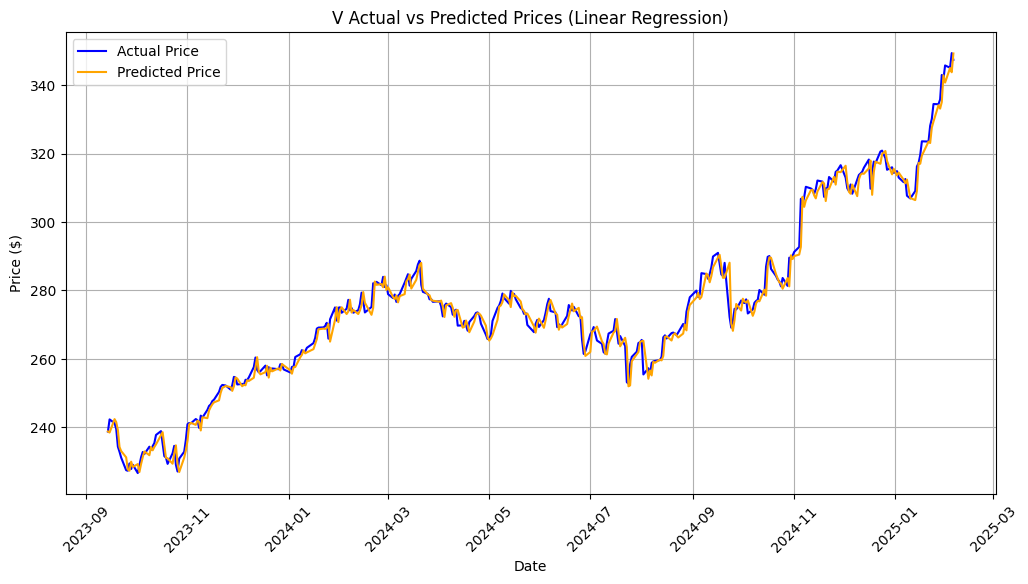

[*********************100%***********************]  1 of 1 completed



Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

META:
  Linear Regression:
    MSE: 104.93
    R2: 0.99
    Predicted Price: $702.48

MA:
  Linear Regression:
    MSE: 24.27
    R2: 0.99
    Predicted Price: $565.89

V:
  Linear Regression:
    MSE: 8.56
    R2: 0.99
    Predicted Price: $349.33

Processing NFLX...

Processed Data:

Price            Close        High         Low        Open    Volume  \
Ticker            NFLX        NFLX        NFLX        NFLX      NFLX   
Date                                                                   
2018-02-07  264.559998  272.450012  264.329987  266.579987   8981500   
2018-02-08  250.100006  267.619995  250.000000  267.079987   9306700   
2018-02-09  249.470001  255.800003  236.110001  253.850006  16906900   
2018-02-12  257.950012  259.149994  249.000000  252.139999   8534900   
2018-02-13  258.269989  261.410004  2

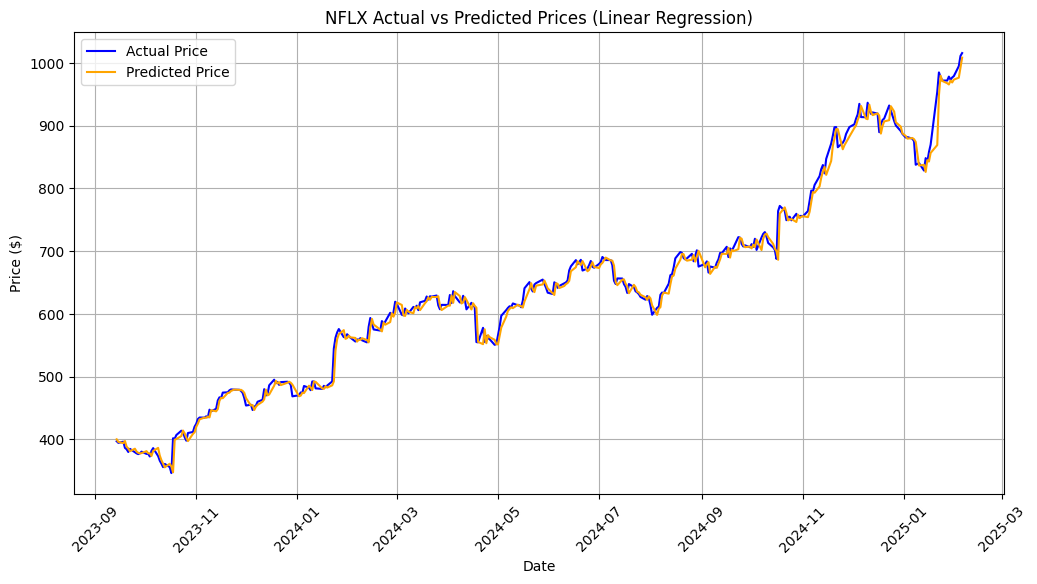

[*********************100%***********************]  1 of 1 completed



Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

META:
  Linear Regression:
    MSE: 104.93
    R2: 0.99
    Predicted Price: $702.48

MA:
  Linear Regression:
    MSE: 24.27
    R2: 0.99
    Predicted Price: $565.89

V:
  Linear Regression:
    MSE: 8.56
    R2: 0.99
    Predicted Price: $349.33

NFLX:
  Linear Regression:
    MSE: 164.33
    R2: 0.99
    Predicted Price: $1008.37

Processing AMZN...

Processed Data:

Price           Close       High        Low       Open     Volume    Return  \
Ticker           AMZN       AMZN       AMZN       AMZN       AMZN             
Date                                                                          
2018-02-07  70.838997  73.049500  70.757500  72.449997  143254000       NaN   
2018-02-08  67.525002  71.687500  67.497002  71.484001  171572000 -0.046782   
2018-02-09  66.980003  69.175003  63.296501  68.674500  282

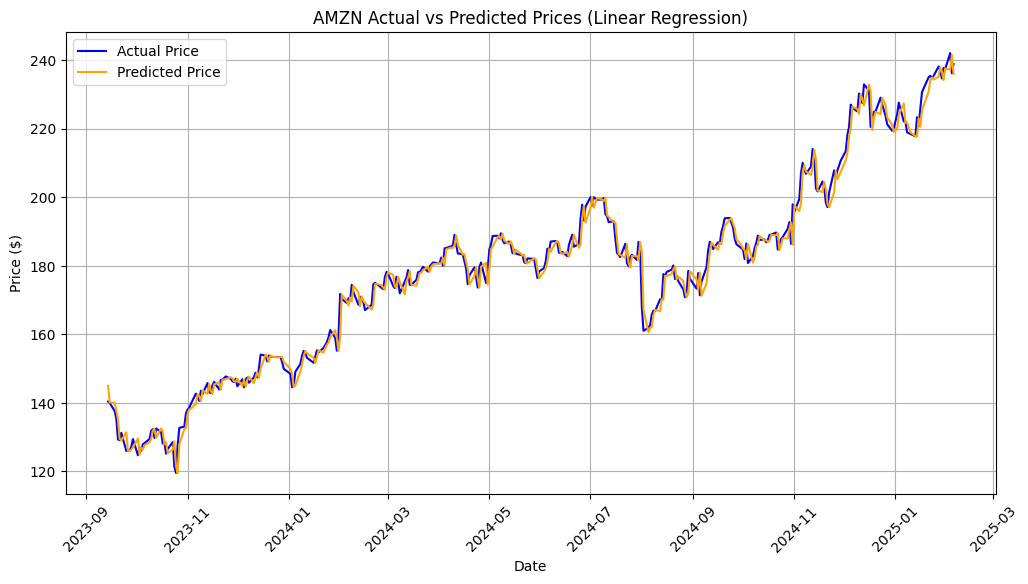


Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

META:
  Linear Regression:
    MSE: 104.93
    R2: 0.99
    Predicted Price: $702.48

MA:
  Linear Regression:
    MSE: 24.27
    R2: 0.99
    Predicted Price: $565.89

V:
  Linear Regression:
    MSE: 8.56
    R2: 0.99
    Predicted Price: $349.33

NFLX:
  Linear Regression:
    MSE: 164.33
    R2: 0.99
    Predicted Price: $1008.37

AMZN:
  Linear Regression:
    MSE: 10.03
    R2: 0.99
    Predicted Price: $235.97

Processing GOOGL...


[*********************100%***********************]  1 of 1 completed



Processed Data:

Price           Close       High        Low       Open    Volume    Return  \
Ticker          GOOGL      GOOGL      GOOGL      GOOGL     GOOGL             
Date                                                                         
2018-02-07  52.579895  54.130275  52.540537  54.052557  51942000       NaN   
2018-02-08  50.203510  53.004354  50.053553  52.802088  66792000 -0.045196   
2018-02-09  52.124542  52.396057  49.669939  51.108724  98360000  0.038265   
2018-02-12  52.537548  53.086059  52.085687  52.642666  56240000  0.007923   
2018-02-13  52.516624  52.869346  52.156928  52.310371  31586000 -0.000398   
2018-02-14  53.441269  53.579269  52.300408  52.525590  41304000  0.017607   
2018-02-15  54.370899  54.507405  53.168756  53.976828  37396000  0.017395   
2018-02-16  54.577152  55.215338  54.380364  54.471532  39948000  0.003793   
2018-02-20  54.980194  55.612899  54.303148  54.440650  33754000  0.007385   
2018-02-21  55.486359  56.604806  55.175485  5

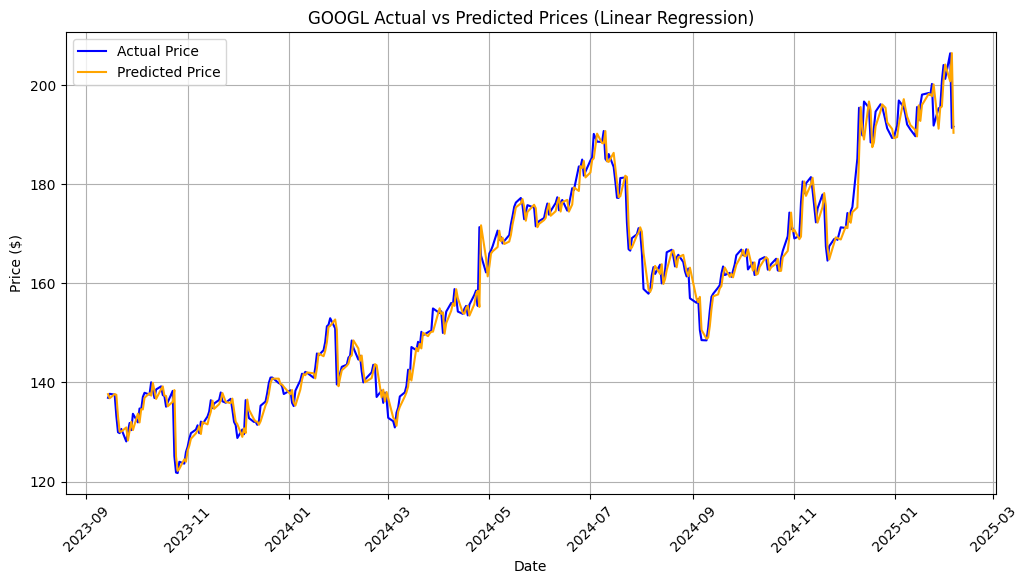


Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

META:
  Linear Regression:
    MSE: 104.93
    R2: 0.99
    Predicted Price: $702.48

MA:
  Linear Regression:
    MSE: 24.27
    R2: 0.99
    Predicted Price: $565.89

V:
  Linear Regression:
    MSE: 8.56
    R2: 0.99
    Predicted Price: $349.33

NFLX:
  Linear Regression:
    MSE: 164.33
    R2: 0.99
    Predicted Price: $1008.37

AMZN:
  Linear Regression:
    MSE: 10.03
    R2: 0.99
    Predicted Price: $235.97

GOOGL:
  Linear Regression:
    MSE: 8.67
    R2: 0.98
    Predicted Price: $190.35

Processing JPM...


[*********************100%***********************]  1 of 1 completed


Processed Data:

Price           Close       High        Low       Open    Volume    Return  \
Ticker            JPM        JPM        JPM        JPM       JPM             
Date                                                                         
2018-02-07  92.607033  93.903379  91.195815  91.524006  21878300       NaN   
2018-02-08  88.512848  92.803935  88.480028  92.803935  27425800 -0.044210   
2018-02-09  90.285095  91.113777  87.159087  89.513846  28188000  0.020022   
2018-02-12  91.679886  92.492161  90.309694  91.212215  18043300  0.015449   
2018-02-13  92.246010  92.754707  90.908638  91.335282  16358200  0.006175   
2018-02-14  94.379234  94.576147  92.328047  92.410093  15186900  0.023125   
2018-02-15  94.773071  95.166896  93.714658  94.961777  12130200  0.004173   
2018-02-16  94.092072  95.232531  93.944386  93.985412  13214300 -0.007186   
2018-02-20  94.116707  94.674630  93.509557  94.067480  13461500  0.000262   
2018-02-21  94.510529  96.364798  94.083878  9

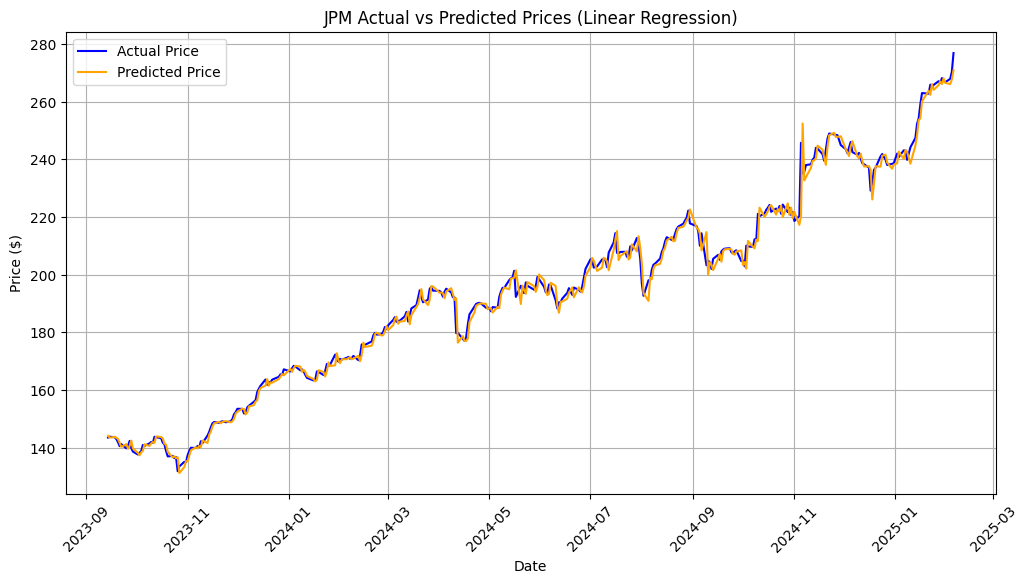


Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

META:
  Linear Regression:
    MSE: 104.93
    R2: 0.99
    Predicted Price: $702.48

MA:
  Linear Regression:
    MSE: 24.27
    R2: 0.99
    Predicted Price: $565.89

V:
  Linear Regression:
    MSE: 8.56
    R2: 0.99
    Predicted Price: $349.33

NFLX:
  Linear Regression:
    MSE: 164.33
    R2: 0.99
    Predicted Price: $1008.37

AMZN:
  Linear Regression:
    MSE: 10.03
    R2: 0.99
    Predicted Price: $235.97

GOOGL:
  Linear Regression:
    MSE: 8.67
    R2: 0.98
    Predicted Price: $190.35

JPM:
  Linear Regression:
    MSE: 8.98
    R2: 0.99
    Predicted Price: $270.95

Processing MSFT...


[*********************100%***********************]  1 of 1 completed


Processed Data:

Price           Close       High        Low       Open    Volume    Return  \
Ticker           MSFT       MSFT       MSFT       MSFT      MSFT             
Date                                                                         
2018-02-07  83.024521  85.025778  82.644649  83.839847  41107600       NaN   
2018-02-08  78.762604  83.274702  78.530976  83.117197  55628700 -0.051333   
2018-02-09  81.699623  82.394505  77.669307  79.957787  63499100  0.037290   
2018-02-12  82.579811  83.182044  81.468002  82.218473  35720300  0.010773   
2018-02-13  83.228401  83.385906  81.347587  82.394541  26407700  0.007854   
2018-02-14  84.531586  84.699141  82.297522  82.390607  34960900  0.015658   
2018-02-15  86.253662  86.309512  84.354703  84.903908  27823900  0.020372   
2018-02-16  85.639297  87.035590  85.453128  86.058183  30596900 -0.007123   
2018-02-20  86.309532  86.626022  84.717759  85.155265  30911700  0.007826   
2018-02-21  85.164581  86.905296  85.164581  8

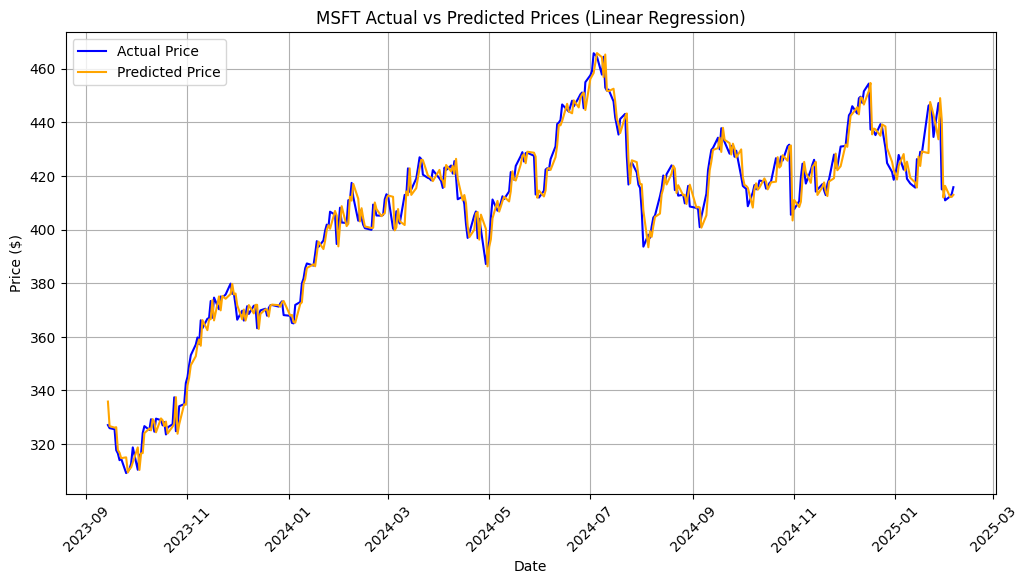


Prediction Summary for 2025-02-10
--------------------------------------------------

TSLA:
  Linear Regression:
    MSE: 92.30
    R2: 0.98
    Predicted Price: $377.82

META:
  Linear Regression:
    MSE: 104.93
    R2: 0.99
    Predicted Price: $702.48

MA:
  Linear Regression:
    MSE: 24.27
    R2: 0.99
    Predicted Price: $565.89

V:
  Linear Regression:
    MSE: 8.56
    R2: 0.99
    Predicted Price: $349.33

NFLX:
  Linear Regression:
    MSE: 164.33
    R2: 0.99
    Predicted Price: $1008.37

AMZN:
  Linear Regression:
    MSE: 10.03
    R2: 0.99
    Predicted Price: $235.97

GOOGL:
  Linear Regression:
    MSE: 8.67
    R2: 0.98
    Predicted Price: $190.35

JPM:
  Linear Regression:
    MSE: 8.98
    R2: 0.99
    Predicted Price: $270.95

MSFT:
  Linear Regression:
    MSE: 29.34
    R2: 0.98
    Predicted Price: $412.96


In [11]:
main()